<a href="https://colab.research.google.com/github/JuanZapa7a/Medical-Image-Processing/blob/main/NB11.%20Medical%20Instance%20Segmentation%20with%20Mask%20RCNN%20Custom%20Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Instance Segmentation with Mask RCNN Custom Finetuning.


## 1. Introduction

Mask R-CNN, an extension of [Faster R-CNN](http://paperswithcode.com/method/faster-r-cnn), enhances its predecessor's capabilities by incorporating a dedicated branch for predicting instance masks alongside the existing bounding box recognition mechanism. This modification enables Mask R-CNN to perform both object detection and pixel-level segmentation within a unified framework, making it a versatile tool for tasks requiring precise object delineation.

Faster R-CNN, initially designed primarily for accurate object localization using region proposal networks (RPNs) and [RoIPool](http://paperswithcode.com/method/roi-pooling) for feature extraction, faced challenges in maintaining pixel-to-pixel alignment due to its coarse spatial quantization approach. This limitation becomes particularly apparent in tasks like instance segmentation, where exact spatial fidelity is critical.

To overcome this, Mask R-CNN introduces [RoIAlign](http://paperswithcode.com/method/roi-align), a refined operation that preserves precise spatial locations during feature extraction from region of interest (RoI) proposals. By eliminating the quantization step present in RoIPool, RoIAlign ensures that the features used for mask prediction align accurately with the corresponding regions in the input image, thereby improving segmentation quality significantly.

### Dataset Overview: NuInsSeg

The [**NuInsSeg dataset**](https://www.kaggle.com/datasets/ipateam/nuinsseg/data) stands out as a comprehensive resource designed specifically for advancing semantic and instance segmentation tasks in histopathology. It comprises over 30,000 manually segmented nuclei originating from 31 different organs of human and mouse subjects, annotated from high-resolution H&E-stained whole slide images. These annotations serve as a foundational dataset for training and evaluating segmentation algorithms.

In addition to nuclei annotations, the dataset includes 665 image patches extracted from these whole slide images, encapsulating a wide range of tissue types and morphologies. This diversity ensures that segmentation models trained on NuInsSeg are robust and capable of handling various biological contexts.

One of the unique features of the NuInsSeg dataset is the provision of ambiguous area masks, which highlight regions where manual segmentation was deemed challenging or impractical. These masks offer insights into the complexities and nuances involved in real-world segmentation tasks, aiding in the development of more robust and generalizable segmentation algorithms.

Overall, the NuInsSeg dataset not only supports the development and benchmarking of instance segmentation algorithms but also contributes significantly to the advancement of automated histopathological analysis, potentially enhancing medical diagnostics and research outcomes.


---
**Install Kaggle API Library**

---

In [1]:
!rm -rf /content/dataset-Nuclei
%pip install -q kaggle


---

**Upload your Kaggle API Key**

---

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


---

**Copy the API key to `~/.kaggle`**

---

In [3]:
# %%capture # util quieres capturar el output de la celda
%mkdir -p ~/.kaggle
%cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls -al ~

total 72
drwx------ 1 root root 4096 Jul 20 09:57 .
drwxr-xr-x 1 root root 4096 Jul 20 09:52 ..
-r-xr-xr-x 1 root root 1169 Jan  1  2000 .bashrc
drwxr-xr-x 1 root root 4096 Jul 18 13:39 .cache
drwxr-xr-x 3 root root 4096 Jul 18 13:39 .config
drwxr-xr-x 5 root root 4096 Jul 18 13:39 .ipython
drwx------ 1 root root 4096 Jul 18 13:39 .jupyter
drwxr-xr-x 2 root root 4096 Jul 20 09:57 .kaggle
drwxr-xr-x 2 root root 4096 Jul 20 09:52 .keras
drwx------ 3 root root 4096 Jul 18 13:14 .launchpadlib
drwxr-xr-x 1 root root 4096 Jul 18 13:39 .local
drwxr-xr-x 4 root root 4096 Jul 18 13:39 .npm
-rw-r--r-- 1 root root  161 Jul  9  2019 .profile
-r-xr-xr-x 1 root root  254 Jan  1  2000 .tmux.conf
-rw-r--r-- 1 root root  211 Jul 18 13:39 .wget-hsts


---
**List kaggle datasets nuiseng**

---

In [4]:
!kaggle datasets list -s "nuinsseg"

ref               title     size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------  --------  ----  -------------------  -------------  ---------  ---------------  
ipateam/nuinsseg  NuInsSeg   2GB  2023-06-12 14:49:00            836         15  0.875            


---

**Download ipateam/nuinsseg**

---


In [5]:
%%time
# Download the dataset from Kaggle (2m.)

from  zipfile import ZipFile
import os

# First, ensure the 'dataset-Nuclei' directory exists

!mkdir -p ./dataset-Nuclei

# Download the dataset from Kaggle in dataset-Nuclei

!kaggle datasets download -d ipateam/nuinsseg -p ./dataset-Nuclei

# Unzip the dataset into the 'dataset-Nuclei' directory

with ZipFile('./dataset-Nuclei/nuinsseg.zip', 'r') as zip_ref:
    zip_ref.extractall('./dataset-Nuclei')

# or simply
#!unzip ./dataset-Nuclei/nuinsseg.zip -d ./dataset-Nuclei -q

# Remove the zip file after extraction (optional)

os.remove('./dataset-Nuclei/nuinsseg.zip')


Dataset URL: https://www.kaggle.com/datasets/ipateam/nuinsseg
License(s): Attribution 4.0 International (CC BY 4.0)
100% 1.51G/1.52G [00:21<00:00, 98.9MB/s]
100% 1.52G/1.52G [00:21<00:00, 75.3MB/s]
CPU times: user 13.8 s, sys: 5.16 s, total: 18.9 s
Wall time: 44 s


---
**List our directory dataset-Nuclei**

---


In [6]:
# Install Pip Tree globally

!sudo apt install tree -q


!tree --dirsfirst -L 2  "dataset-Nuclei"

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (83.7 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 123586 files and directories currently installed.)
Preparing

## 2. Data Preparation


Clean up of the Nuclei dataset
Can be downloaded from: https://www.kaggle.com/datasets/ipateam/nuinsseg?resource=download

The dataset comes with a lot of subdirectories that can be very useful depending
on the task of your interest. For our Mask RCNN and Ultralytics training, we just
need the raw images and labeled masks that we will convert to appropriate formats.
So let us delete all unwanted data and keep only the raw images, binary masks
and label masks.

Keep the directories with names `'tissue images'`, `'mask binary without border'`, and `'label masks modify'`.

---

**Pruning innecesary sub-subdirectories**

---

In [7]:
import os
import shutil

base_directory = "dataset-Nuclei"
directories_to_keep = ['tissue images',
                       'mask binary without border',
                       'label masks modify']

#Iterate through each subdirs in base dir
for root_dir in os.listdir(base_directory):
  root_path = os.path.join(base_directory,root_dir)
  if os.path.isdir(root_path):
        # print(f"Processing: {root_path}")
    #List all subdirs inside the current root dir
    for sub_dir in os.listdir(root_path):
      sub_path = os.path.join(root_path, sub_dir)
      #If the subdirectory isn't in the keep list, delete it
      if os.path.isdir(sub_path) and sub_dir not in directories_to_keep:
        # print(f"Deleting: {sub_path}")
        shutil.rmtree(sub_path)
      elif os.path.isdir(sub_path):
        # print(f"Keeping: {sub_path}")
        pass



---


**List prunned directory**



---



In [8]:
!tree --dirsfirst -L 2  "dataset-Nuclei"

dataset-Nuclei
├── human bladder
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human brain
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human cardia
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human cerebellum
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human epiglottis
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human jejunum
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human kidney
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human liver
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human lung
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human melanoma
│   ├── label masks modify
│   ├── mask binary with

## 3. Displaying Images from Dataset

Next code selects a certain number of images from a directory containing images of `tissue`, calculates the appropriate layout for subplots based on the number of images, and displays the images in the subplots using matplotlib.

---

**Display some images from dataset**

---


 Displaying images from dataset-Nuclei/human umbilical cord/label masks modify 



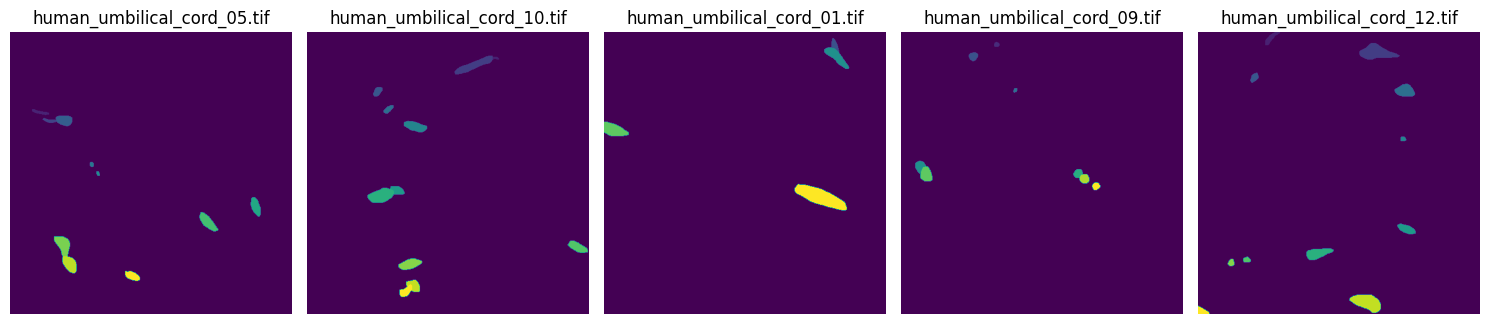


 Displaying images from dataset-Nuclei/human umbilical cord/tissue images 



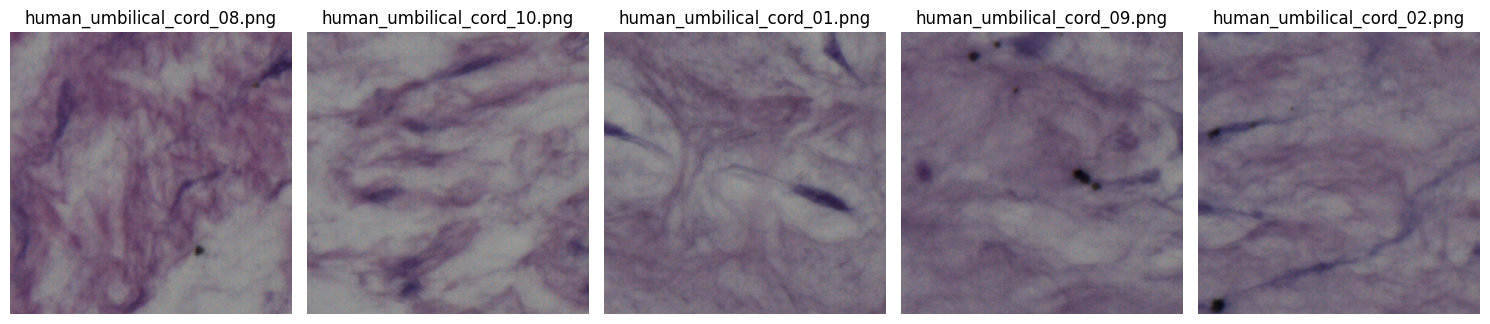


 Displaying images from dataset-Nuclei/human umbilical cord/mask binary without border 



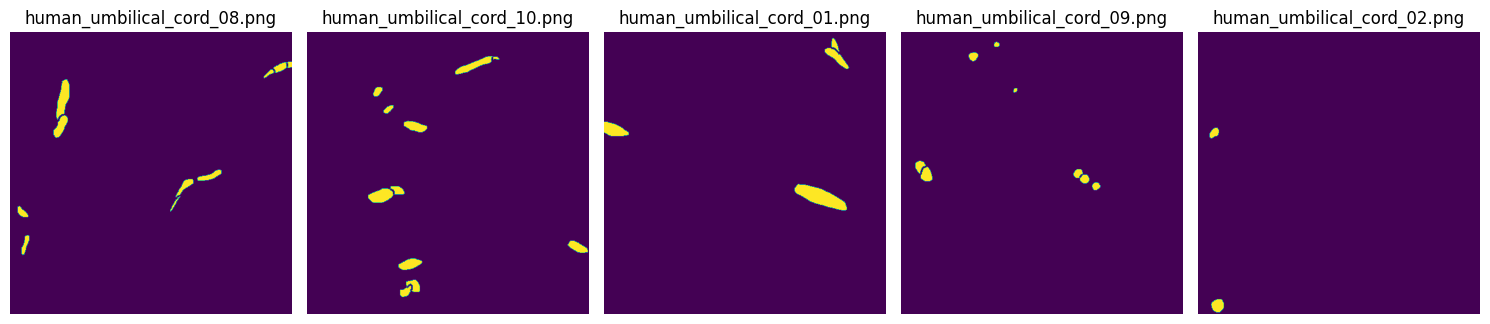

In [9]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Directory containing images
base_directory = "dataset-Nuclei"

# List of subdirectories in the base directory
subdirectories = [d for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]

# Select a random subdirectory from subdirectories
random_subdirectory = random.choice(subdirectories)
random_subdirectory_path = os.path.join(base_directory, random_subdirectory)

# List of sub-subdirectories in the random subdirectory
subsubdirectories = [d for d in os.listdir(random_subdirectory_path) if os.path.isdir(os.path.join(random_subdirectory_path, d))]

# Function to display images from a directory
def display_images_from_directory(directory, max_images=5):
    image_extensions = ['.tif', '.png']
    image_files = [f for f in os.listdir(directory) if any(f.endswith(ext) for ext in image_extensions)]

    plt.figure(figsize=(15, 10))
    for i, image_file in enumerate(image_files[:max_images]):  # Displaying up to max_images
        img_path = os.path.join(directory, image_file)
        img = Image.open(img_path)
        plt.subplot(1, max_images, i + 1)
        plt.imshow(img)
        plt.title(os.path.basename(img_path))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display images from each sub-subdirectory
for subsubdirectory in subsubdirectories:
    subsubdirectory_path = os.path.join(random_subdirectory_path, subsubdirectory)
    print(f"\n Displaying images from {subsubdirectory_path} \n")
    display_images_from_directory(subsubdirectory_path)


We need to convert Label Masks to Coco Json single file annotation. We will convert our labeled mask image annotations to coco json
format so they can be used in training Mask R-CNN.

For it we will use

The get_image_mask_pairs function traverses a data directory, finds all PNG images in directories that contain 'tissue images', and builds a list of their paths along with the paths of their corresponding masks, assuming the masks are in a parallel directory named 'label masks modify' and have a '.tif' extension. This function is useful for preparing pairs of image and mask data for further processing or analysis.



The mask_to_polygons function processes a binary mask to extract contours, reshapes these contours into polygons (a flat list of coordinates), and ensures that each polygon has a valid number of points. This is useful for converting segmentation masks into a format suitable for COCO annotations or other applications that require polygon representations of objects.

This code processes all images in the subdirectories and sub-subdirectories of the base directory, checks if they are binary, extracts polygons from the contours, and generates a coco.json file with the corresponding annotations.

---

**Mask_to_polygons_to COCO.json**

---

In [10]:
%%time
import os
import json
import numpy as np
import cv2
from PIL import Image

# Directory containing images
base_directory = "dataset-Nuclei"

# List of subdirectories in the base directory
subdirectories = [d for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]

# Function to check if an image is binary
def is_binary_image(image_path):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img_np = np.array(img)
    unique_values = np.unique(img_np)
    return len(unique_values) == 2 and set(unique_values).issubset({0, 255})

# Function to find contours in a binary image and convert them to polygons
def get_polygons_from_mask(mask_image):
    mask_np = np.array(mask_image)
    contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = [contour.flatten().tolist() for contour in contours if len(contour) >= 3]
    return polygons

# Initialize COCO structure
coco_data = {
    "images": [],
    "annotations": [],
    "categories": [{"id": 1, "name": "nucleus", "supercategory": "object"}]
}

annotation_id = 1

# Process each subdirectory and its sub-subdirectories
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(base_directory, subdirectory)
    subsubdirectories = [d for d in os.listdir(subdirectory_path) if os.path.isdir(os.path.join(subdirectory_path, d))]

    for subsubdirectory in subsubdirectories:
        subsubdirectory_path = os.path.join(subdirectory_path, subsubdirectory)
        image_files = [f for f in os.listdir(subsubdirectory_path) if any(f.endswith(ext) for ext in ['.tif', '.png'])]

        for image_file in image_files:
            img_path = os.path.join(subsubdirectory_path, image_file)
            img = Image.open(img_path).convert('L')  # Convert to grayscale

            if is_binary_image(img_path):
                img_np = np.array(img)
                height, width = img_np.shape
                polygons = get_polygons_from_mask(img_np)

                if polygons:
                    coco_data["images"].append({
                        "id": len(coco_data["images"]) + 1,
                        "file_name": image_file,
                        "height": height,
                        "width": width
                    })

                    for polygon in polygons:
                        coco_data["annotations"].append({
                            "id": annotation_id,
                            "image_id": len(coco_data["images"]),
                            "category_id": 1,
                            "segmentation": [polygon],
                            "area": cv2.contourArea(np.array(polygon).reshape((-1, 2))),
                            "bbox": cv2.boundingRect(np.array(polygon).reshape((-1, 2))),
                            "iscrowd": 0
                        })
                        annotation_id += 1

# Save the data in COCO JSON format
with open("coco_annotations.json", "w") as outfile:
    json.dump(coco_data, outfile, indent=4)

print("Conversion complete. File saved as coco_annotations.json")


Conversion complete. File saved as coco_annotations.json
CPU times: user 34.2 s, sys: 961 ms, total: 35.2 s
Wall time: 39.9 s


## 4. Displaying annotations from Dataset


---

**Libraries and auxiliar functions**

---

In [11]:
import json
import os
import random
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Directory containing images
base_directory = "dataset-Nuclei"

# Function to get all sub-subdirectories from the base directory
def get_all_image_paths(base_directory):
    image_paths = {}
    subdirectories = [d for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]
    for subdirectory in subdirectories:
        subdirectory_path = os.path.join(base_directory, subdirectory)
        subsubdirectories = [d for d in os.listdir(subdirectory_path) if os.path.isdir(os.path.join(subdirectory_path, d))]
        for subsubdirectory in subsubdirectories:
            subsubdirectory_path = os.path.join(subdirectory_path, subsubdirectory)
            image_files = [f for f in os.listdir(subsubdirectory_path) if any(f.endswith(ext) for ext in ['.png', '.png'])]
            for image_file in image_files:
                image_path = os.path.join(subsubdirectory_path, image_file)
                image_paths[image_file] = image_path
    return image_paths

# Get all image paths
image_paths = get_all_image_paths(base_directory)


---

**Load COCO Annotations and Map Image IDs**

---

In [12]:
# Load COCO annotations
with open('coco_annotations.json') as f:
    coco_data = json.load(f)

# Create dictionaries to map image IDs to image data and file names to image data
image_id_to_data = {img['id']: img for img in coco_data['images']}
file_name_to_id = {img['file_name']: img['id'] for img in coco_data['images']}

---

**Visualize Images and Annotations**

---

In [13]:
# Function to visualize a single image and its annotations
def visualize_image(image_data, annotations, ax):
    file_name = image_data['file_name']
    img_path = image_paths.get(file_name)

    if img_path is None:
        print(f"Image file {file_name} not found in any of the subdirectories.")
        return

    # Load the image
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')

    # Overlay the annotations
    for ann in annotations:
        if ann['image_id'] == image_data['id']:
            polygon = np.array(ann['segmentation'][0]).reshape(-1, 2)
            poly = Polygon(polygon, facecolor='none', edgecolor='r')
            ax.add_patch(poly)

    ax.set_title(f"ID: {image_data['id']}")


---

**Randomly Select and Visualize 10 Images**

---

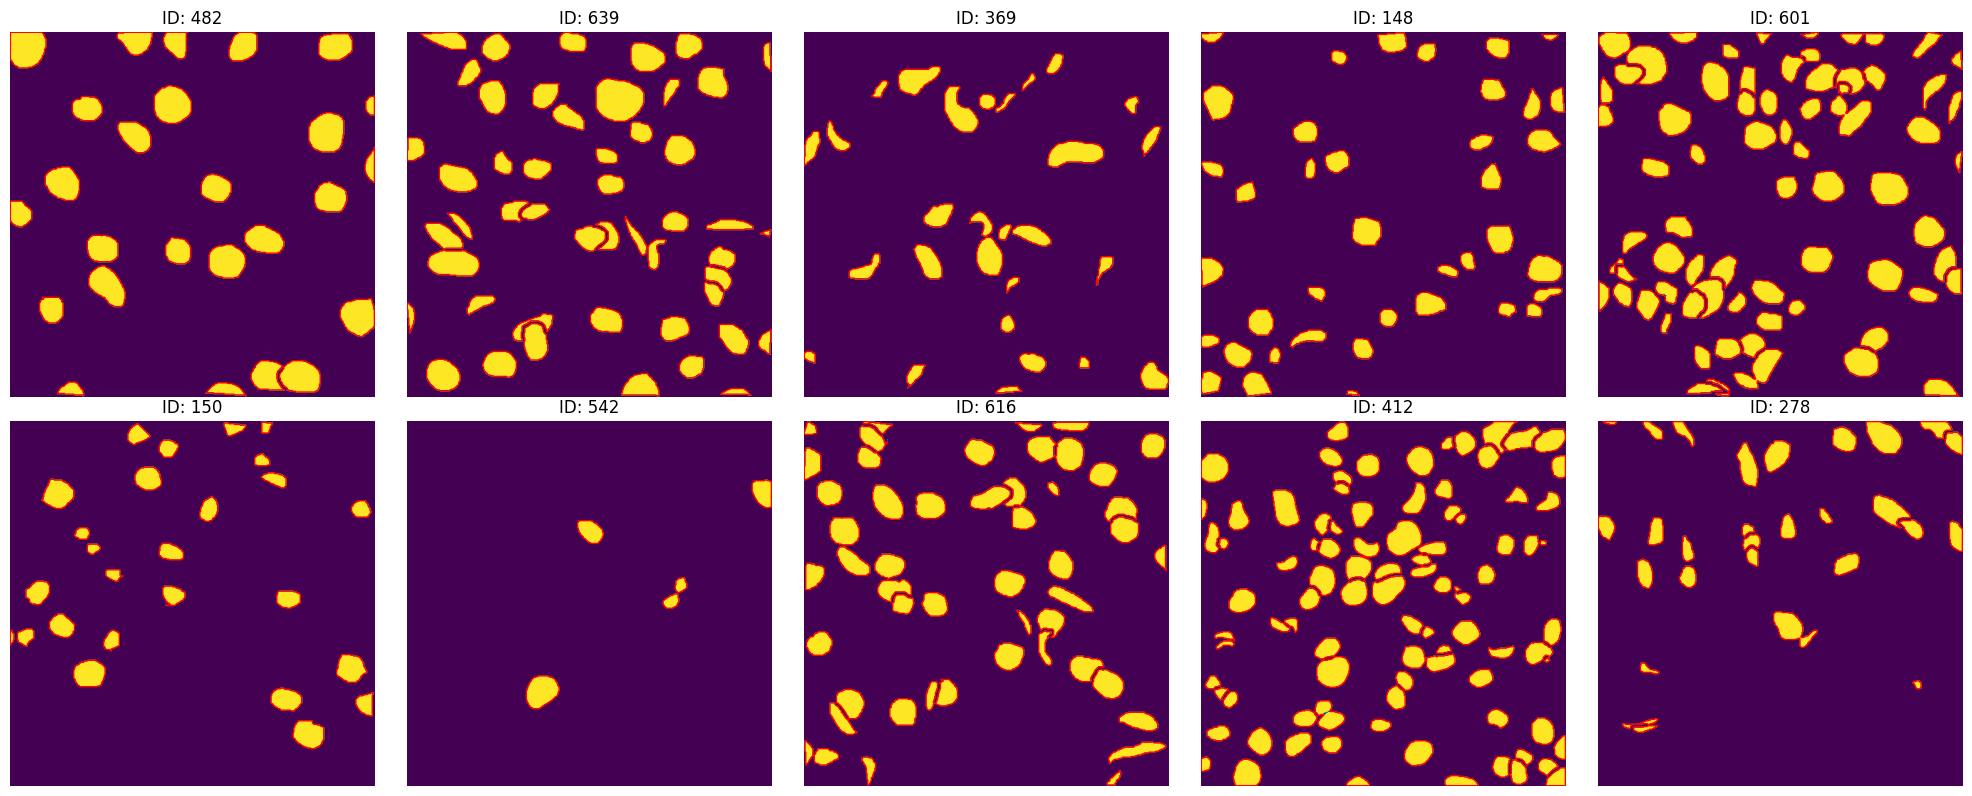

In [14]:
# Randomly select 10 images
random_images = random.sample(coco_data['images'], 10)

# Create a plot with 2 rows and 5 columns
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.flatten()

# Visualize each selected image and its annotations
for ax, img_data in zip(axs, random_images):
    image_id = img_data['id']
    annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]
    visualize_image(img_data, annotations, ax)

plt.tight_layout()
plt.show()


---

**Print JSON File Lines**

---

In [15]:
# Print the first few lines of the coco_annotations.json file
with open('coco_annotations.json', 'r') as f:
    for _ in range(24):  # Adjust the number of lines as needed
        print(f.readline().strip())


{
"images": [
{
"id": 1,
"file_name": "mouse_liver_23.png",
"height": 512,
"width": 512
},
{
"id": 2,
"file_name": "mouse_liver_22.png",
"height": 512,
"width": 512
},
{
"id": 3,
"file_name": "mouse_liver_21.png",
"height": 512,
"width": 512
},
{
"id": 4,
"file_name": "mouse_liver_17.png",
"height": 512,


---

**Print Polygon Coordinates**

---

In [16]:
# Function to print the polygon coordinates for a random image
def print_polygon_coordinates(image_data, annotations):
    print(f"Image ID: {image_data['id']}, File Name: {image_data['file_name']}")
    for ann in annotations:
        if ann['image_id'] == image_data['id']:
            print(f"  Annotation ID: {ann['id']}, Polygon Coordinates: {ann['segmentation'][0]}")


In [17]:
# Print polygon coordinates for the 10 random images
for img_data in random_images:
    image_id = img_data['id']
    annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]
    print_polygon_coordinates(img_data, annotations)

Image ID: 482, File Name: human_liver_39.png
  Annotation ID: 18094, Polygon Coordinates: [291, 492, 290, 493, 288, 493, 285, 496, 284, 496, 277, 503, 277, 504, 276, 505, 275, 505, 274, 506, 285, 506, 286, 507, 300, 507, 301, 508, 314, 508, 315, 509, 329, 509, 330, 510, 331, 510, 330, 509, 330, 508, 329, 508, 328, 507, 328, 506, 326, 504, 326, 503, 320, 497, 319, 497, 318, 496, 317, 496, 316, 495, 315, 495, 314, 494, 312, 494, 311, 493, 305, 493, 304, 492]
  Annotation ID: 18095, Polygon Coordinates: [81, 491, 81, 492, 80, 493, 79, 493, 75, 497, 73, 497, 69, 501, 69, 502, 67, 504, 67, 506, 66, 507, 76, 507, 77, 508, 89, 508, 90, 509, 101, 509, 102, 510, 103, 510, 103, 506, 102, 505, 102, 503, 101, 502, 101, 501, 100, 501, 99, 500, 99, 499, 96, 496, 96, 495, 94, 493, 94, 492, 92, 492, 91, 491]
  Annotation ID: 18096, Polygon Coordinates: [396, 461, 395, 462, 394, 462, 392, 464, 391, 464, 390, 465, 389, 465, 385, 469, 384, 469, 383, 470, 384, 471, 384, 472, 382, 474, 382, 475, 379, 478, 

## 4. Organize Image Data

---

**Split your images and annotations into training and validation sets.**

---

In [18]:
# Function to split dataset into training and validation
def split_dataset(coco_data, split_ratio=0.8):
    # Randomly shuffle the images
    images = coco_data['images']
    random.shuffle(images)

    # Split images into train and validation sets
    split_index = int(len(images) * split_ratio)
    train_images = images[:split_index]
    val_images = images[split_index:]

    # Get image IDs for the split
    train_image_ids = {img['id'] for img in train_images}
    val_image_ids = {img['id'] for img in val_images}

    # Filter annotations based on the split image IDs
    train_annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] in train_image_ids]
    val_annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] in val_image_ids]

    # Create split data
    train_data = {
        'images': train_images,
        'annotations': train_annotations,
        'categories': coco_data['categories']
    }

    val_data = {
        'images': val_images,
        'annotations': val_annotations,
        'categories': coco_data['categories']
    }

    return train_data, val_data

# Split the dataset
train_data, val_data = split_dataset(coco_data, split_ratio=0.8)


---

**Create COCO Annotation Files for Train and Validation Sets**

---

In [19]:
# Define paths for the new COCO annotation files
train_annotation_path = 'train2017.json'
val_annotation_path = 'val2017.json'

# Save the annotations to JSON files
with open(train_annotation_path, 'w') as f:
    json.dump(train_data, f, indent=4)

with open(val_annotation_path, 'w') as f:
    json.dump(val_data, f, indent=4)

# Create directories for train and val datasets
os.makedirs('train2017', exist_ok=True)
os.makedirs('val2017', exist_ok=True)

# Function to move images to their respective directories
def move_images(data, image_paths, target_dir):
    for image in data['images']:
        image_file = image['file_name']
        if image_file in image_paths:
            source_path = image_paths[image_file]
            target_path = os.path.join(target_dir, image_file)
            shutil.move(source_path, target_path)
        else:
            print(f"Image {image_file} does not exist in image_paths and cannot be moved.")

# Move images to train2017 and val2017 directories
move_images(train_data, image_paths, 'train2017')
move_images(val_data, image_paths, 'val2017')


---

**Visualizar 10 imagenes de cada directorio (train2017 y val2017) para comprobar.**

---

In [20]:
import json
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from matplotlib.patches import Polygon

# Load COCO annotations for train and val sets
with open('train2017.json') as f:
    train_coco_data = json.load(f)

with open('val2017.json') as f:
    val_coco_data = json.load(f)

# Create dictionaries to map image IDs and file names to image data
train_file_name_to_data = {img['file_name']: img for img in train_coco_data['images']}
val_file_name_to_data = {img['file_name']: img for img in val_coco_data['images']}

# Function to get image path
def get_image_path(file_name, base_directory):
    return os.path.join(base_directory, file_name)


In [21]:
# Function to visualize a single image with annotations
def visualize_image(image_data, annotations, ax, base_directory):
    file_name = image_data['file_name']
    img_path = get_image_path(file_name, base_directory)

    if not os.path.isfile(img_path):
        print(f"Image file {file_name} not found.")
        return

    # Load the image
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')

    # Overlay annotations
    for ann in annotations:
        if ann['image_id'] == image_data['id']:
            # Draw polygons
            polygon = np.array(ann['segmentation'][0]).reshape(-1, 2)
            poly = Polygon(polygon, facecolor='none', edgecolor='r')
            ax.add_patch(poly)

    ax.set_title(f"ID: {image_data['id']}")


In [22]:
import random

# Function to select random images and their annotations
def get_random_images_and_annotations(coco_data, num_images=10):
    images = coco_data['images']
    random_images = random.sample(images, num_images)
    image_ids = {img['id'] for img in random_images}
    annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] in image_ids]
    return random_images, annotations

# Select random images from train and val datasets
train_images, train_annotations = get_random_images_and_annotations(train_coco_data, num_images=10)
val_images, val_annotations = get_random_images_and_annotations(val_coco_data, num_images=10)


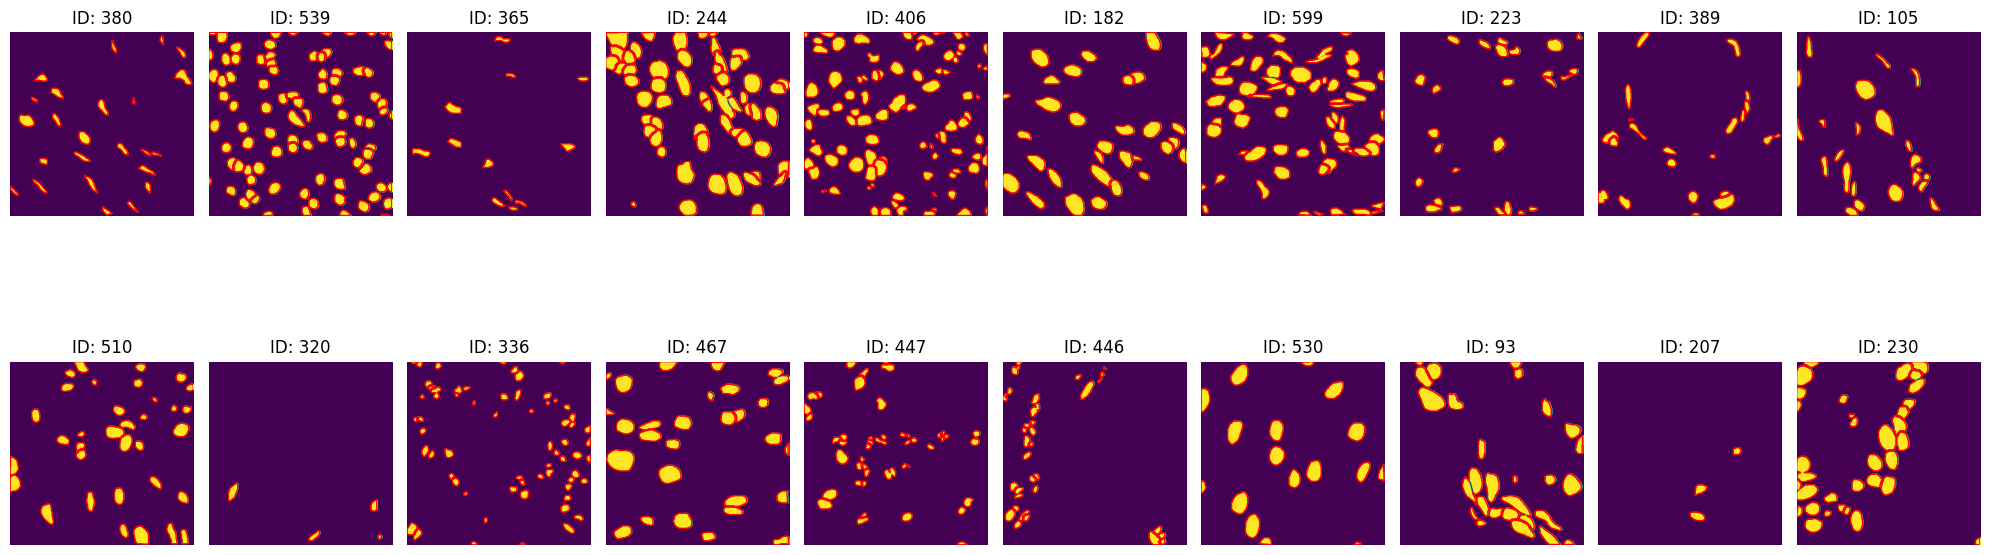

In [23]:
# Set base directories for train and val images
train_base_directory = 'train2017'
val_base_directory = 'val2017'

# Plot images from train and validation sets
fig, axs = plt.subplots(2, 10, figsize=(20, 8))

# Plot train images
for ax, img_data in zip(axs[0], train_images):
    image_id = img_data['id']
    annotations = [ann for ann in train_annotations if ann['image_id'] == image_id]
    visualize_image(img_data, annotations, ax, train_base_directory)

# Plot val images
for ax, img_data in zip(axs[1], val_images):
    image_id = img_data['id']
    annotations = [ann for ann in val_annotations if ann['image_id'] == image_id]
    visualize_image(img_data, annotations, ax, val_base_directory)

plt.tight_layout()
plt.show()


In [24]:
import os

# List files in the train2017 and val2017 directories
train_files = os.listdir(train_base_directory)
val_files = os.listdir(val_base_directory)

print("Files in train2017 directory:")
print(train_files[:10])  # Print first 10 files for quick checking

print("Files in val2017 directory:")
print(val_files[:10])  # Print first 10 files for quick checking


Files in train2017 directory:
['mouse_subscapula_42.png', 'human_testis_3.png', 'human_kidney_03.png', 'mouse_subscapula_02.png', 'mouse_muscle_tibia_09.png', 'human_jejunum_10.png', 'mouse_liver_23.png', 'human_oesophagus_34.png', 'mouse_kidney_28.png', 'mouse_spleen_02.png']
Files in val2017 directory:
['human_spleen_07.png', 'human_cerebellum_3.png', 'human_salivory_33.png', 'human_pancreas_17.png', 'human_pylorus_6.png', 'human_salivory_38.png', 'mouse_muscle_tibia_02.png', 'human_spleen_30.png', 'human_umbilical_cord_08.png', 'human_tongue_13.png']


## 5. Fine-tune Mask R-CNN for medical instance segmentation

First, install Detectron2 and other necessary dependencies

---
**Set up the environment** (time 6 minutes aprox)

---

In [25]:
%%time
!pip install -q torch torchvision
!pip install -q git+https://github.com/facebookresearch/detectron2.git
!pip install -q opencv-python
!pip install -q matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 52.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
CPU times: user 2.43 s, sys: 296 ms, total: 2.72 s
Wall time: 6min 22s



Use a Python script to configure and train the Mask R-CNN model with detectron2.

---
**Configure the Mask R-CNN model**

---

In [26]:
%%time
import os
import json
import random
import numpy as np
import cv2
import torch
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2.data.datasets import register_coco_instances

# Register COCO datasets
register_coco_instances("nuclei_train", {}, "train2017.json", "train2017")
register_coco_instances("nuclei_val", {}, "val2017.json", "val2017")

# Configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("nuclei_train",)
cfg.DATASETS.TEST = ("nuclei_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000    # Adjust this as needed
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64  # Adjust this as needed
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only one class (e.g., Nucleus)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Train the model
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Save the final weights
final_weights_path = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
torch.save(trainer.model.state_dict(), final_weights_path)


[07/20 10:05:43 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 93.8MB/s]                          
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[07/20 10:05:47 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[07/20 10:06:03 d2.utils.events]:  eta: 0:06:06  iter: 19  total_loss: 3.787  loss_cls: 0.6891  loss_box_reg: 0.6631  loss_mask: 0.6856  loss_rpn_cls: 1.661  loss_rpn_loc: 0.1515    time: 0.3868  last_time: 0.4895  data_time: 0.0372  last_data_time: 0.0361   lr: 4.9953e-06  max_mem: 2026M
[07/20 10:06:18 d2.utils.events]:  eta: 0:05:15  iter: 39  total_loss: 2.446  loss_cls: 0.6392  loss_box_reg: 0.754  loss_mask: 0.673  loss_rpn_cls: 0.3086  loss_rpn_loc: 0.09677    time: 0.3506  last_time: 0.2501  data_time: 0.0123  last_data_time: 0.0131   lr: 9.9902e-06  max_mem: 2026M
[07/20 10:06:25 d2.utils.events]:  eta: 0:05:15  iter: 59  total_loss: 2.213  loss_cls: 0.5731  loss_box_reg: 0.7656  loss_mask: 0.6373  loss_rpn_cls: 0.1278  loss_rpn_loc: 0.08893    time: 0.3474  last_time: 0.3438  data_time: 0.0167  last_data_time: 0.0154   lr: 1.4985e-05  max_mem: 2026M
[07/20 10:06:32 d2.utils.events]:  eta: 0:05:04  iter: 79  total_loss: 2.066  loss_cls: 0.5204  loss_box_reg: 0.757  loss_mask: 

---
**Evaluate the model**

---

In [27]:
# Load the trained model
cfg.MODEL.WEIGHTS = final_weights_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

# Evaluate the model on the validation dataset
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("nuclei_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "nuclei_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))


[07/20 10:11:58 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
WARNING [07/20 10:11:58 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[07/20 10:11:58 d2.data.datasets.coco]: Loaded 133 images in COCO format from val2017.json
[07/20 10:11:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/20 10:11:58 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[07/20 10:11:58 d2.data.common]: Serializing 133 elements to byte tensors and concatenating them all ...
[07/20 10:11:58 d2.data.common]: Serialized dataset takes 1.45 MiB
[07/20 10:11:58 d2.evaluation.evaluator]: Start inference on 133 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[07/20 10:12:01 d2.evaluation.evaluator]: Inference done 11/133. Dataloading: 0.0047 s/iter. Inference: 0.1139 s/iter. Eval: 0.0449 s/iter. Total: 0.1635 s/iter. ETA=0:00:19
[07/20 10:12:06 d2.evaluation.evaluator]: Inference done 34/133. Dataloading: 0.0087 s/iter. Inference: 0.1526 s/iter. Eval: 0.0520 s/iter. Total: 0.2136 s/iter. ETA=0:00:21
[07/20 10:12:11 d2.evaluation.evaluator]: Inference done 53/133. Dataloading: 0.0127 s/iter. Inference: 0.1604 s/iter. Eval: 0.0672 s/iter. Total: 0.2406 s/iter. ETA=0:00:19
[07/20 10:12:16 d2.evaluation.evaluator]: Inference done 76/133. Dataloading: 0.0122 s/iter. Inference: 0.1550 s/iter. Eval: 0.0656 s/iter. Total: 0.2331 s/iter. ETA=0:00:13
[07/20 10:12:21 d2.evaluation.evaluator]: Inference done 106/133. Dataloading: 0.0114 s/iter. Inference: 0.1413 s/iter. Eval: 0.0611 s/iter. Total: 0.2141 s/iter. ETA=0:00:05
[07/20 10:12:26 d2.evaluation.evaluator]: Inference done 130/133. Dataloading: 0.0107 s/iter. Inference: 0.1395 s/iter. Eval: 0.0

---
**Visualize Results**

---

[07/20 10:12:30 d2.data.datasets.coco]: Loaded 133 images in COCO format from val2017.json


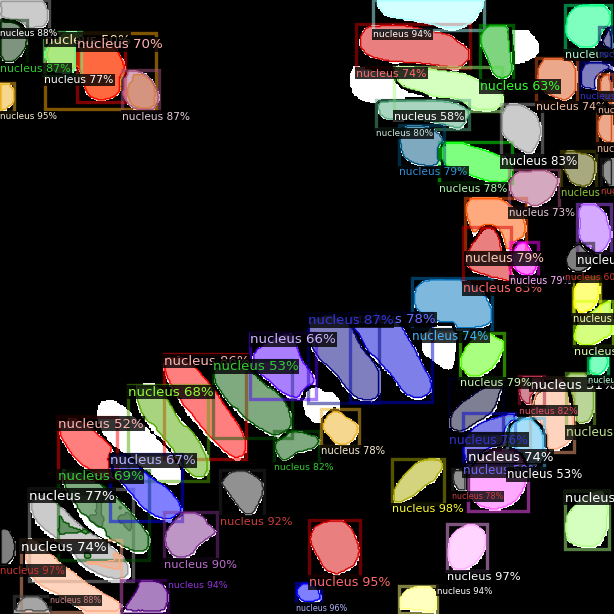

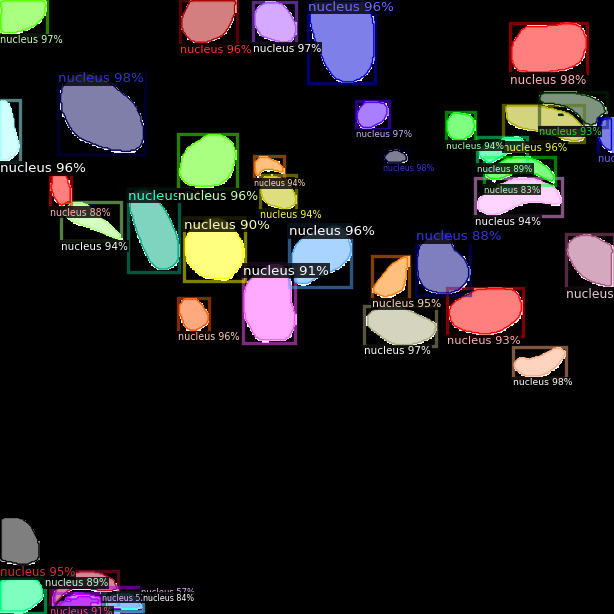

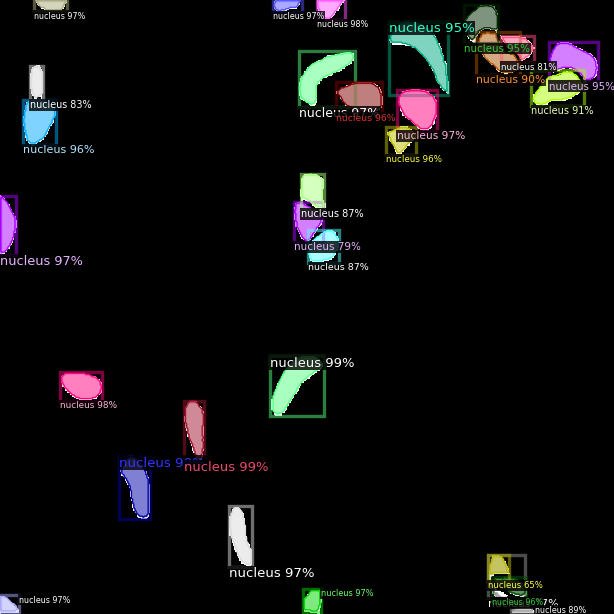

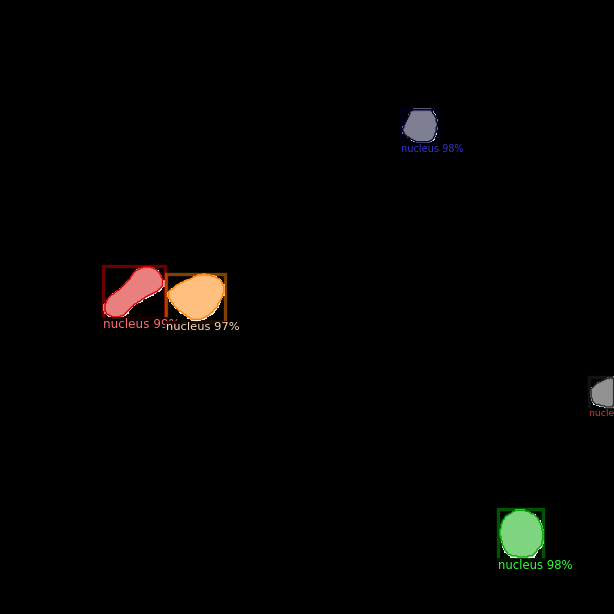

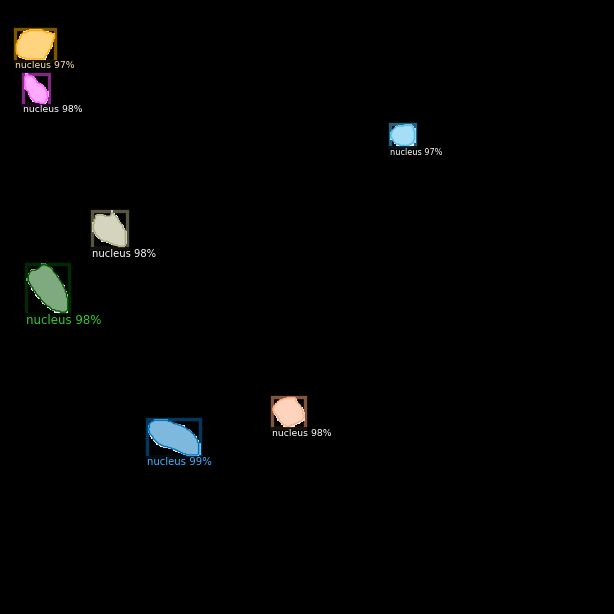

In [28]:
from google.colab.patches import cv2_imshow

dataset_dicts = DatasetCatalog.get("nuclei_val")

for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get("nuclei_val"), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])
    cv2.waitKey(0)
cv2.destroyAllWindows()


[07/20 10:12:33 d2.data.datasets.coco]: Loaded 133 images in COCO format from val2017.json


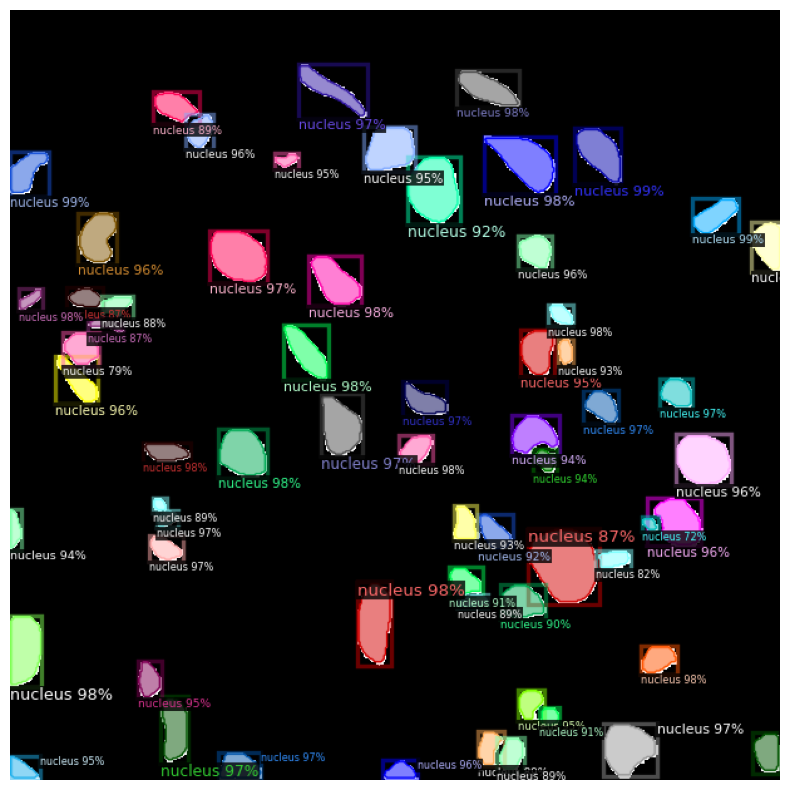

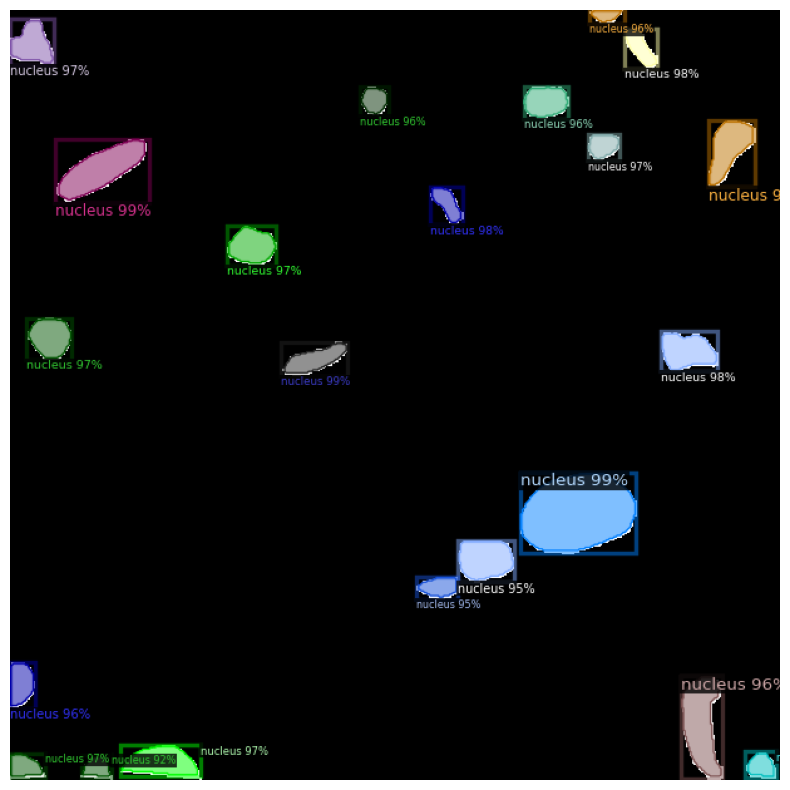

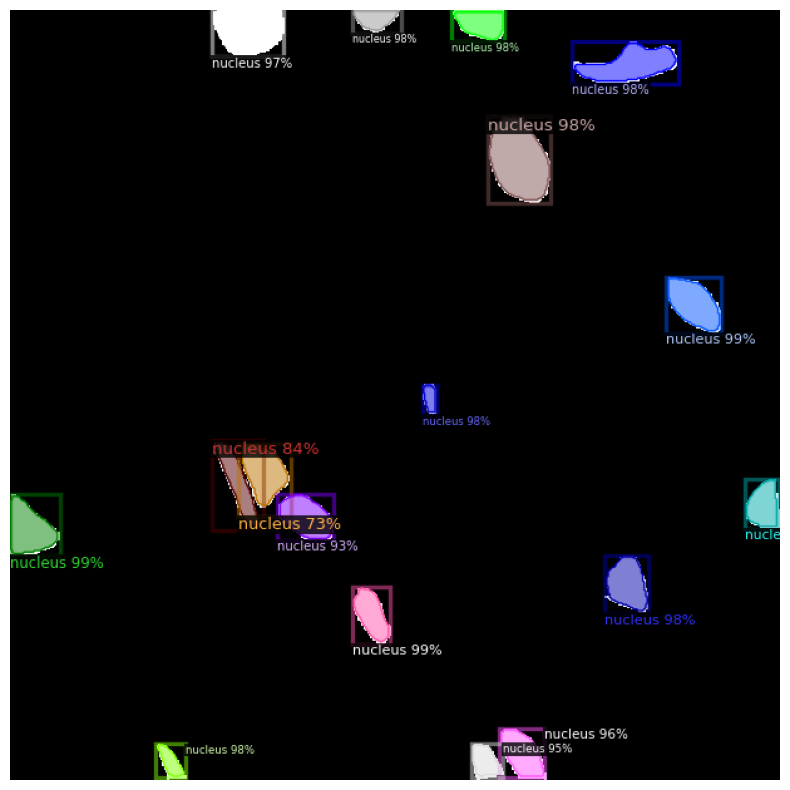

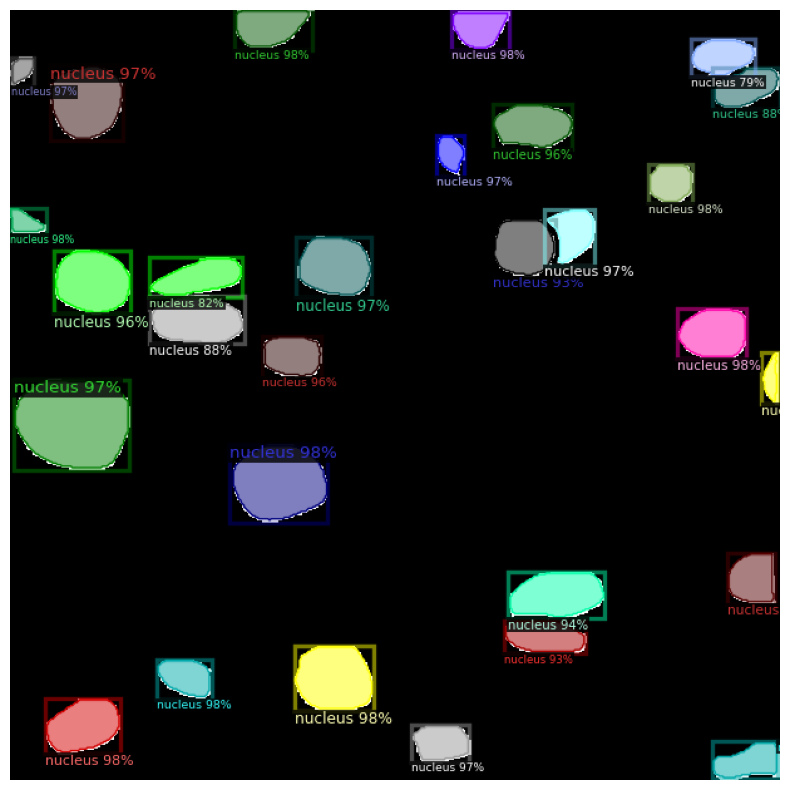

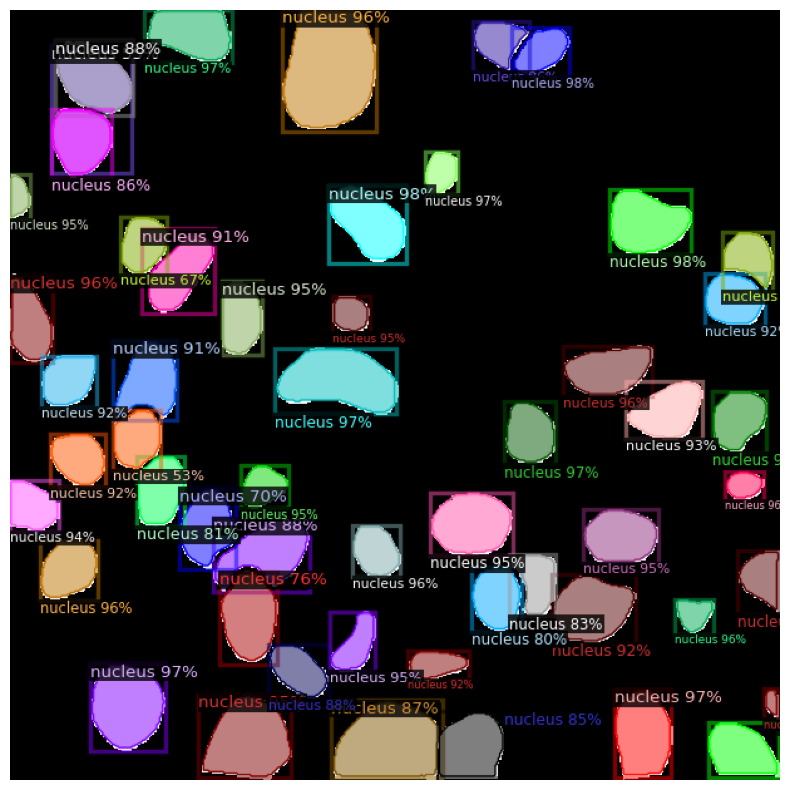

In [29]:
import matplotlib.pyplot as plt
from detectron2.data import DatasetCatalog
import random
import cv2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Assuming `predictor` is already defined and configured

# Get dataset dictionary
dataset_dicts = DatasetCatalog.get("nuclei_val")

# Plot images and annotations
for d in random.sample(dataset_dicts, 5):
    # Read the image
    img = cv2.imread(d["file_name"])

    # Run inference
    outputs = predictor(img)

    # Visualize the result
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get("nuclei_val"), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Convert image from BGR to RGB for matplotlib
    result_img = out.get_image()[:, :, ::-1]

    # Display the image using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(result_img)
    plt.axis('off')  # Hide axes
    plt.show()


In [35]:
!sudo apt-get update
!sudo apt-get install -y locales
!sudo locale-gen en_US.UTF-8
!sudo update-locale LANG=en_US.UTF-8
!export LC_ALL=en_US.UTF-8
!export LANG=en_US.UTF-8

# After setting the locale, try installing the package again
!pip install -q ultralytics


NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968